In [200]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torchmetrics import SymmetricMeanAbsolutePercentageError
from torch.utils.data import Dataset,DataLoader,TensorDataset
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import BaseModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import Baseline
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from typing import Dict
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os
#os.chdir("..")

In [201]:
df = pd.read_csv('Data/All_music.csv')
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.drop("Unnamed: 0",inplace=True,axis=1)
df.set_index("timestamp",inplace=True)

df = df["2020-12-14":]

df["dayofweek"] = df.index.dayofweek.astype("int32")
df["log_views"] = np.log(df["views"] + 1e-8)
df["month"] = df.index.month.astype("int32")
df["year"] = df.index.year.astype("int32")
df["avg_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("mean").astype("float64")
df["min_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("min").astype("float64")
df["max_by_song_month"] = df.groupby(["month","year","article"],observed=True)["views"].transform("max").astype("float64")

for i in range(1, 8):
    df[f"t-{i}"] = df["views"].shift(i).ffill()

df = df.iloc[7:]
features = ["dayofweek", "month", "year", "min_by_song_month", "max_by_song_month", "avg_by_song_month","log_views", "t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7"]
target = "views"

In [202]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, x, y, sequence_length=5):
        self.y = y
        self.X = x
        self.sequence_length = sequence_length

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [203]:
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_x = torch.tensor(train[features].values).to(device)
train_y = torch.tensor(train[target].values).unsqueeze(1).to(device)
test_x = torch.tensor(test[features].values).to(device)
test_y = torch.tensor(test[target].values).unsqueeze(1).to(device)

torch.manual_seed(101)


train_dataset = SequenceDataset(
    x=train_x,
    y=train_y,
    sequence_length=1
)
test_dataset = SequenceDataset(
    x=test_x,
    y=test_y,
    sequence_length=1
)

train_loader = DataLoader(train_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

x, y = next(iter(train_loader))

print("Features shape:", x.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 1, 14])
Target shape: torch.Size([1, 1])


In [204]:
class LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 50 # number of hidden states
        self.n_layers = 2 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True).to(device)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1).to(device)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).to(device)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).to(device)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [205]:
def smape(target, forecast):
  if type(target) == pd.core.frame.DataFrame:
    target = target.values

  denominator = np.abs(target) + np.abs(forecast)
  flag = denominator == 0.

  smape = 2 * np.mean(
      (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
  )
  return smape

In [ ]:
learning_rate = 0.0001

model = LSTM(n_features=14,seq_length=1).to(device)
loss_function = SymmetricMeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for x, y in data_loader:
        x,y = x.to(device),y.to(device)
        model.init_hidden(x.size(0))
        output = model(x.float())
        loss = loss_function(output,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x,y = x.to(device),y.to(device)
            model.init_hidden(x.size(0))
            output = model(x.float())
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

epoch = 2
for ix_epoch in range(epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()
path = "lstm_new.pth"    
#torch.save(model.state_dict(),path)

In [8]:
path = "lstm_new.pth"    
model.load_state_dict(torch.load(path))
model.eval()

LSTM(
  (l_lstm): LSTM(14, 50, num_layers=2, batch_first=True)
  (l_linear): Linear(in_features=50, out_features=1, bias=True)
)

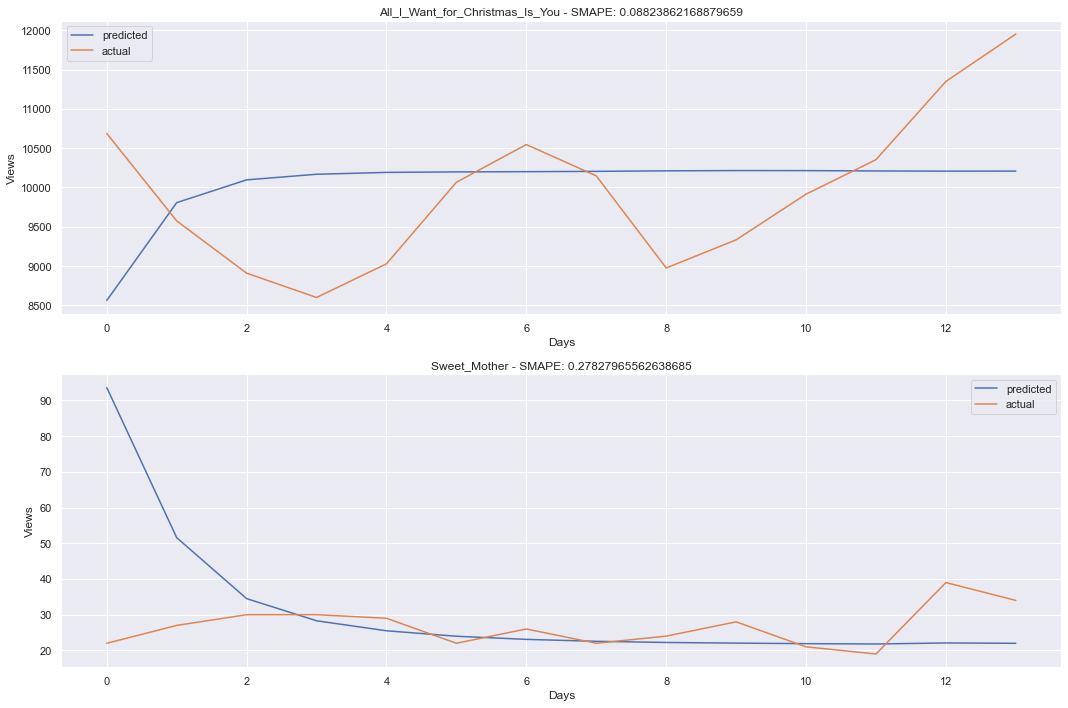

In [228]:
import matplotlib.pyplot as plt
model.eval()


fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10),tight_layout=True)
fig.tight_layout()


song1 = df[df["article"] == "All_I_Want_for_Christmas_Is_You"][features][-28:-14].values
actual1 = df[df["article"] == "All_I_Want_for_Christmas_Is_You"][target][-28:-14].values.flatten()
preds1 = []
loss1 = []
with torch.no_grad():
    for i in range(14):
        temp = torch.tensor(np.array(song1[i])).unsqueeze(0).unsqueeze(0).to(device).float()
        predictions = model(temp)
        preds1.append(predictions.cpu().detach().numpy())
        loss1.append(smape(predictions.flatten().cpu().detach().numpy(),actual1[i]))

loss1 = np.average(np.array(loss1))
preds1 = np.array(preds1).flatten()

axs[0].plot(preds1,label="predicted")
axs[0].plot(actual1,label="actual")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Views")
axs[0].title.set_text(f"All_I_Want_for_Christmas_Is_You - SMAPE: {loss1}")



song2 = df[df["article"] == "Sweet_Mother"][features][-28:-14].values
actual2 = df[df["article"] == "Sweet_Mother"][target][-28:-14].values.flatten()
preds2 = []
loss2 = []
with torch.no_grad():
    for i in range(14):
        temp = torch.tensor(np.array(song2[i])).unsqueeze(0).unsqueeze(0).to(device).float()
        predictions = model(temp)
        preds2.append(predictions.cpu().detach().numpy())
        loss = smape(predictions.flatten().cpu().detach().numpy(),actual2[i])
        loss2.append(loss)

loss2 = np.average(np.array(loss2))
preds2 = np.array(preds2).flatten()

axs[1].plot(preds2,label="predicted")
axs[1].plot(actual2,label="actual")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Views")
axs[1].title.set_text(f"Sweet_Mother - SMAPE: {loss2}")


# plt.show()

In [195]:
import plotly.express as px
import pandas as pd

df_ = pd.DataFrame({"Time":[668,73],
                   "Model":["LSTM","LSTM"],
                   "Training Type":["Training","Optimizing"]
                   })
fig = px.bar(df_,y="Time",x="Model",color="Training Type",text="Time",color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(title="Time in Minutes")
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=1.25,
    bgcolor="LightSteelBlue",
),title={
    "text":"Training Time",
    "x":0.45
})
min = 99999
max = 0

counter = 0
temp = 0
for t,_,_ in df_.values:
    temp += t
    counter += 1
    if counter == 2:
        if temp> max:
            max = temp
        elif temp < min:
            min = temp
        temp = 0
        counter = 0

#fig.add_hline(min,line_width=3,line_dash="dash",line_color="#4ae004")
#fig.add_hline(max,line_width=3,line_dash="dash",line_color="red")
fig.update_traces(width=0.4)
fig.add_annotation(x=0, y=760,
            text="Total: 741 Minutes (12h:21m)",
            showarrow=False,font_size=15,font_family="Arial Black")
fig.show()
fig.write_image("training_time.png",format='png',engine='kaleido',scale=3)


<AxesSubplot:>

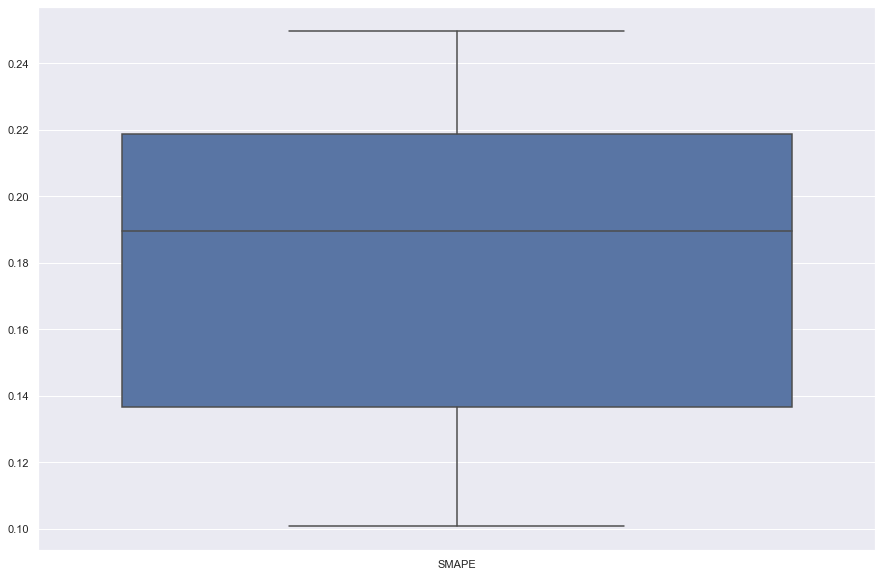

In [229]:
import seaborn as sns
losses = {"SMAPE":[]}
for song in df["article"].unique():
    input = df[df["article"] == song][features][-28:-14].values
    actual = df[df["article"] == song][target][-28:-14].values.flatten() 

    preds = np.zeros(len(input))
    for i,v in enumerate(input):
        temp = torch.tensor(np.array(input[i])).unsqueeze(0).unsqueeze(0).to(device).float()
        preds[i] = model(temp) / 8
    losses["SMAPE"].append(smape(actual,preds.flatten()))
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=pd.DataFrame(data=losses),orient="v")